In [1]:
import anndata
import scanpy as sc
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import pandas as pd
import umap
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from keras.callbacks import EarlyStopping
import seaborn as sb

adata = sc.read('/tmp/work/RCproject_code/sce_export.h5ad')

/opt/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
2024-10-16 08:20:42.499897: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `a

In [2]:
# generate numerical values for each batch category
from sklearn.preprocessing import LabelEncoder
# set up categories variable
categories = adata.obs['batch']
# Create a LabelEncoder instance
label_encoder = LabelEncoder()
# Fit and transform the categories to integers
numerical_categories = label_encoder.fit_transform(categories)
numerical_categories.shape

(450,)

In [3]:
#normalizaiton
gene_expression_data = adata.layers['logcounts']
from sklearn.preprocessing import MinMaxScaler
# Min-max normalization
scaler = MinMaxScaler()
gene_expression_data = scaler.fit_transform(gene_expression_data)
number_samples = adata.shape[0]
number_genes = adata.shape[1]
input_dim = number_genes

In [4]:
input_shape = (12165,)  # Set to match your actual data
encoding_dim = 64  # Output dimension

In [5]:
from keras import layers, models

# Define the input shape
input_shape = (12165,)  # Number of genes

# Define the encoder function
def build_encoder():
    model = models.Sequential()
    model.add(layers.Input(shape=(12165,)))  # Set to match the input shape of 12165
    model.add(layers.Dense(256, activation='linear'))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(128, activation='linear'))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(64, activation='linear'))  # Encoded representation
    return model

# Define the decoder function (adjusted as discussed)
def build_decoder():    
    model = models.Sequential()
    model.add(layers.Input(shape=(64,)))  # Input shape should match the output of the encoder
    model.add(layers.Dense(128, activation='linear'))  
    model.add(layers.LeakyReLU())    
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(256, activation='linear'))  
    model.add(layers.LeakyReLU())    
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(12165, activation='sigmoid'))  # Output layer should match the input shape of the original data
    return model

In [6]:
# Define the domain classifier function
def build_domain_classifier(input_shape, num_domains):
    model = models.Sequential()    
    model.add(layers.Input(shape=input_shape))    
    model.add(layers.Dense(128, activation=None))
    model.add(layers.LeakyReLU()) 
    model.add(layers.BatchNormalization())    
    model.add(layers.Dense(64, activation=None))
    model.add(layers.LeakyReLU()) 
    model.add(layers.BatchNormalization())    
    model.add(layers.Dense(32, activation=None))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())    
    model.add(layers.Dense(num_domains, activation='softmax'))  # num_domains is the number of classes
    return model

In [7]:
class GradientReversalLayer(tf.keras.layers.Layer):
    def __init__(self, lambda_value=1.0, **kwargs):
        self.lambda_value = lambda_value
        super(GradientReversalLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Define custom gradient behavior
        @tf.custom_gradient
        def reverse_gradients(x):
            # Forward pass: output is just the input
            def grad(dy):
                # Gradient computation: reversed and scaled by lambda_value
                return -self.lambda_value * dy
            return x, grad
        
        return reverse_gradients(inputs)

    def get_config(self):
        config = super().get_config()
        config.update({"lambda_value": self.lambda_value})
        return config

In [8]:
# Define the encoder, decoder, and discriminator (assuming these functions are defined as in previous examples)
encoder = build_encoder()  # Assuming build_encoder() is defined
decoder = build_decoder()  # Assuming build_decoder() is defined
discriminator = build_domain_classifier((64,), 9)  # Assuming build_domain_classifier() is defined

# Optimizers for each model
encoder_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
decoder_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Assuming you have 1000 training samples as an example
num_samples = adata.shape[0]  # Replace this with your actual number of samples
batch_size = 32

# Training loop
num_epochs = 400

# Calculate the number of steps per epoch
num_steps_per_epoch = num_samples // batch_size

# Compile the discriminator
discriminator.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Create a combined model for the encoder and decoder if training together
# combined_model = models.Sequential([encoder, decoder])

# # Compile combined model
# combined_model.compile(optimizer='adam', loss='mean_squared_error')  # Use an appropriate loss for your case

In [9]:
num_domains = len(np.unique(categories))
X_data = gene_expression_data
y_domains = numerical_categories
grl = GradientReversalLayer(lambda_value=2.0)  # Instantiate GRL

reconstruction_losses = []  # To store averaged reconstruction loss values per epoch
domain_losses = []          # To store averaged domain loss values per epoch


# Training loop
for epoch in range(num_epochs):
    # Initialize accumulators for the epoch
    total_reconstruction_loss = 0.0
    total_domain_loss = 0.0
    num_batches = 0  # To count batches in the current epoch

    for step in range(num_steps_per_epoch):
        # Get a batch of data
        batch_indices = []
        for domain in range(num_domains):
            domain_indices = np.where(y_domains == domain)[0]
            domain_batch_indices = np.random.choice(domain_indices, size=batch_size // num_domains, replace=True)
            batch_indices.append(domain_batch_indices)

        X_batch = X_data[np.concatenate(batch_indices)]
        y_true_batch = y_domains[np.concatenate(batch_indices)]
        y_true = tf.keras.utils.to_categorical(y_true_batch, num_classes=9)  # Convert labels to categorical

        
        # Train on reconstruction loss
        with tf.GradientTape(persistent = True) as autoencoder_tape:
            # Encode
            encoded_output = encoder(X_batch, training=True)

            # Decode
            decoded_output = decoder(encoded_output, training=True)

            # Calculate reconstruction loss
            reconstruction_loss = tf.reduce_mean(tf.square(X_batch - decoded_output))

        # Calculate gradients for encoder and decoder using the same tape
        encoder_gradients = autoencoder_tape.gradient(reconstruction_loss, encoder.trainable_variables)
        decoder_gradients = autoencoder_tape.gradient(reconstruction_loss, decoder.trainable_variables)

        #update the encoder and the decoder
        encoder_optimizer.apply_gradients(zip(encoder_gradients, encoder.trainable_variables))
        decoder_optimizer.apply_gradients(zip(decoder_gradients, decoder.trainable_variables))

        # Now, train on domain loss using a new tape
        with tf.GradientTape(persistent = True) as discriminator_tape:

            # Encode
            encoded_output = encoder(X_batch, training=True)
            
            # Apply gradient reversal
            encoded_output_grl = grl(encoded_output)

            # Domain output
            domain_output = discriminator(encoded_output_grl, training=True)

            # Calculate domain loss
            domain_loss = tf.keras.losses.categorical_crossentropy(y_true, domain_output)
            domain_loss = tf.reduce_mean(domain_loss)  # Average over the batch

        # Calculate gradients for the discriminator and the encdoer
        encoder_gradients = discriminator_tape.gradient(domain_loss, encoder.trainable_variables)
        discriminator_gradients = discriminator_tape.gradient(domain_loss, discriminator.trainable_variables)

        # Update discriminator
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
        encoder_optimizer.apply_gradients(zip(encoder_gradients, encoder.trainable_variables))

        # Accumulate losses
        total_reconstruction_loss += reconstruction_loss.numpy()
        total_domain_loss += domain_loss.numpy()
        num_batches += 1

    # Calculate average losses for the epoch (same as before)
    average_reconstruction_loss = total_reconstruction_loss / num_batches
    average_domain_loss = total_domain_loss / num_batches

    # Store and print average losses
    reconstruction_losses.append(average_reconstruction_loss)
    domain_losses.append(average_domain_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Average Reconstruction Loss: {average_reconstruction_loss}")
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Domain Loss: {average_domain_loss}")

Epoch 1/400, Average Reconstruction Loss: 0.05386476218700409
Epoch 1/400, Average Domain Loss: 3.6129522834505354
Epoch 2/400, Average Reconstruction Loss: 0.013128348825765508
Epoch 2/400, Average Domain Loss: 3.1633996282305037
Epoch 3/400, Average Reconstruction Loss: 0.008446600454460298
Epoch 3/400, Average Domain Loss: 2.7853952135358537
Epoch 4/400, Average Reconstruction Loss: 0.007608874368348292
Epoch 4/400, Average Domain Loss: 2.451447708266122
Epoch 5/400, Average Reconstruction Loss: 0.006953162207667317
Epoch 5/400, Average Domain Loss: 2.6596979924610684
Epoch 6/400, Average Reconstruction Loss: 0.006540240520345313
Epoch 6/400, Average Domain Loss: 2.343770010130746
Epoch 7/400, Average Reconstruction Loss: 0.006909580668434501
Epoch 7/400, Average Domain Loss: 2.322951308318547
Epoch 8/400, Average Reconstruction Loss: 0.0062468042597174644
Epoch 8/400, Average Domain Loss: 1.9338679228510176
Epoch 9/400, Average Reconstruction Loss: 0.006023750540667346
Epoch 9/400,

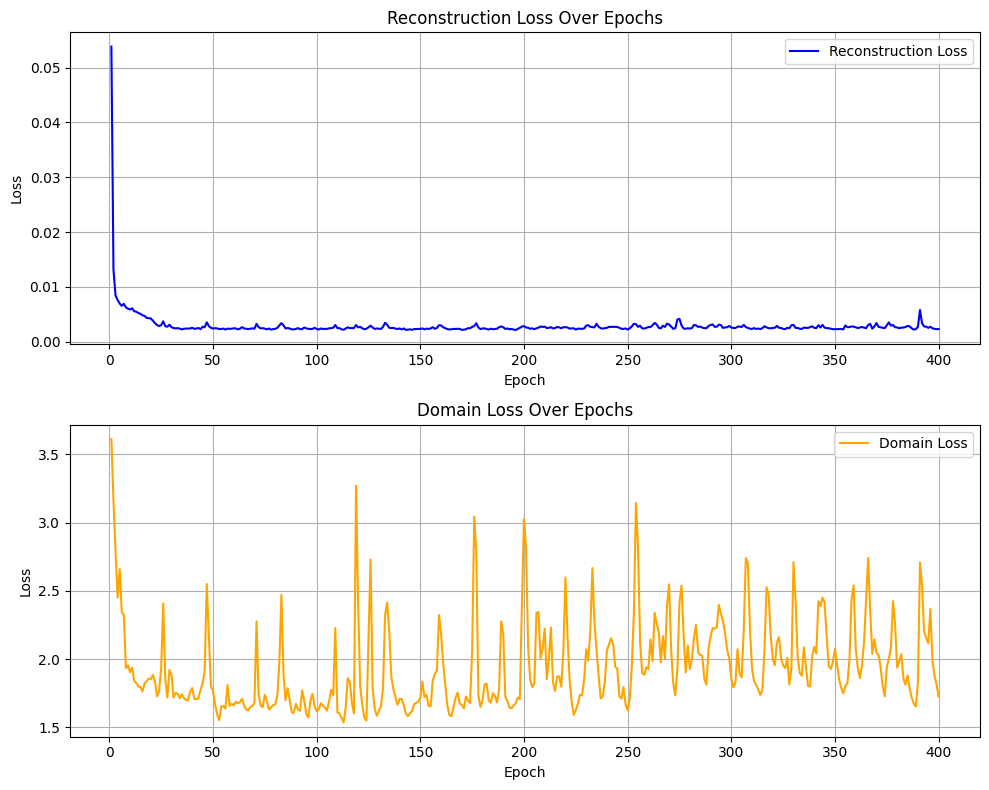

In [10]:
# After training, plot the losses
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot Reconstruction Loss
axs[0].plot(range(1, num_epochs + 1), reconstruction_losses, label='Reconstruction Loss', color='blue')
axs[0].set_title('Reconstruction Loss Over Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].grid()
axs[0].legend()

# Plot Domain Loss
axs[1].plot(range(1, num_epochs + 1), domain_losses, label='Domain Loss', color='orange')
axs[1].set_title('Domain Loss Over Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].grid()
axs[1].legend()

plt.tight_layout()
plt.show()

15/15 [==============================] - 0s 2ms/step
(450, 64)


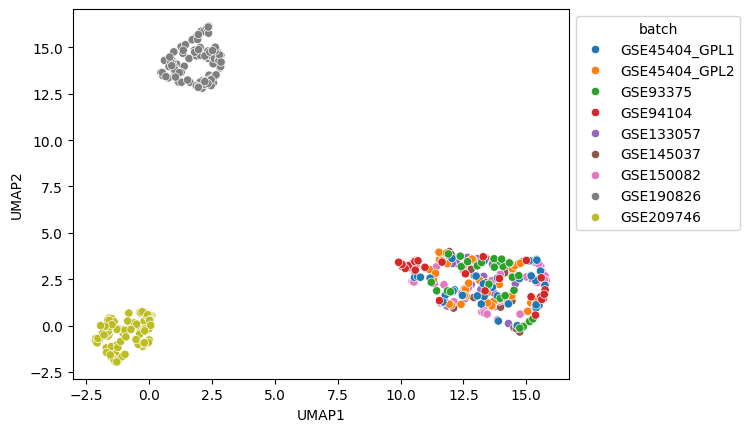

In [11]:
#grab the represetations from the trained model
low_dimensional_representation = encoder.predict(gene_expression_data)

#verify the shape
print(low_dimensional_representation.shape)

#set up the umap

umap_model = umap.UMAP(n_neighbors=15,   # Controls local vs global structure
                        min_dist=0.1,    # Controls how tightly UMAP packs points together
                        metric='euclidean')  # Distance metric to use

umap_result = umap_model.fit_transform(low_dimensional_representation)

#checking batch separation
categories =  adata.obs['batch']
umap_data = {'UMAP1': umap_result[:, 0], 'UMAP2': umap_result[:, 1],'batch':categories}
umap_df = pd.DataFrame(data=umap_data)
ax = sb.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='batch')
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

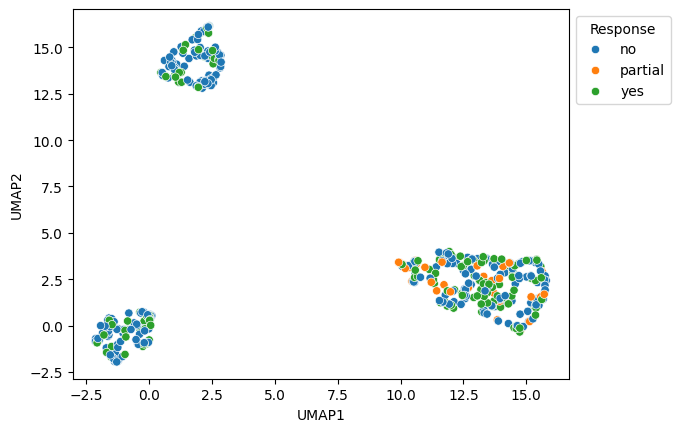

In [12]:
#checking response variable separation
categories =  adata.obs['Response']
umap_data = {'UMAP1': umap_result[:, 0], 'UMAP2': umap_result[:, 1],'Response':categories}
umap_df = pd.DataFrame(data=umap_data)
ax = sb.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='Response')
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))